# Switch / Light example


In [297]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re

### concept system modeling in literature

based on TNO report: Guided root analysis of machine failure, par 5.2

a system is an assembly of components and connections between components

how to define a component?
- define inputs and outputs
- define failure modes
- inputs and outputs are associated with modalities and a modality has properties
- relation between inputs and outputs for normal behavior and for every failure mode

how to define an assembly
- components that are part of the assembly
- how the components are connected

limitations/prerequisites system modeling
- every component has one health and one output variable. multiple inputs are possible

### generate influence diagram from system definition

implementation below uses following steps
- define component (inputs/outputs, ...) as dict
- define connection as dict
- define system as dict
- generate nodes from dict and add as variable in influence diagram
- generate arcs from dict and add to influence diagram

### component specification

In [298]:
# component Switch > Python datastructure dictionary

switch = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"]
        }
    }

}

In [299]:
# component Light > Python datastructure dictionary

light = {
    "type":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"]
        }
    }
}

### connections connect components 
- connections have a name
- connections have two named components and a direction
- connections have a health that is connected to the component that is addressed by the connection

In [301]:
wire = {
    "type":"Wire",
    "start":"PresentPowerOutputs",
    "typeStart":"Switch",
    "end":"PresentPowerInputs",
    "typeEnd":"Light"
}

### system defines assembly
system consists of components and connections between them

In [303]:
system = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        }
    }
}

In [300]:
# method reads component specification (as dict)
# per modality a variable is generated and added to diagram

def addComponentToDiagram(diag, comp, name):
    componentkeys = ["Inputs","Outputs","Healths"]
    keys = comp.keys()
    labels = []
        
    # read inputs, outputs and health, add named variable to diagram 
    for ckey in componentkeys:
        if ckey in keys:  
            for modality in comp[ckey].keys():                                             # get modalities
                modalitylabel = comp[ckey][modality]["modality"]                           # get modality label
                property = comp[ckey][modality]["property"]                                # get property label
                propertyvalues = comp[ckey][modality]["propertyvalues"]                    # get property values
                if(ckey == "Healths"):                                                     # shorter name for health
                    label = str(property + name)
                else:
                    label = str(property + modalitylabel + ckey + name)                    # name variable
                labels.append(label)
                diag.addChanceNode(gum.LabelizedVariable(label, label, propertyvalues))    # add variable to diagram

    # add arcs to connect inputs / health nodes to output within component
    inputvars = []
    for label in labels:
        if(re.search("Inputs", label)):
            inputvars.append(diag.idFromName(label))
        if(re.search("health", label)):
            hvar = diag.idFromName(label)
        if(re.search("Outputs",label)):
            ovar = diag.idFromName(label)
    # add arc for health to output
    diag.addArc(hvar, ovar)
    # add arc for every input to output
    for v in inputvars:
        diag.addArc(v,ovar)        
    

In [302]:
# connect components in diagram via given connection
# add health to connection

def addConnectionToDiagram(diag, name, connection, startComponent, endComponent):
    diaglabels = diag.names()
    for label in diaglabels:
        if(re.search(startComponent, label)):
            if(re.search(connection['start'], label)):
                startvar = diag.idFromName(label)
        elif(re.search(endComponent, label)):
            if(re.search(connection['end'], label)):
                endvar = diag.idFromName(label)
    diag.addArc(startvar, endvar)
    label = str("health" + name)
    hvar = diag.addChanceNode(gum.LabelizedVariable(label,label,["ok","broken"]))
    diag.addArc(hvar, endvar)

In [306]:
componentDictList =[light, switch]
connectionsDictList = [wire]

def getDictByType1(componentType):
    print(componentType)
    for c in componentDictList:
        if(c["type"] == componentType):
            return c

def getDictByType2(connectionType):
    for c in connectionsDictList:
        if(c["type"] == connectionType):
            return c        
        
def addComponents(diag, y):
    for k, v in y.items():
        addComponentToDiagram(diag, getDictByType1(v["type"]) ,v['name'])

def addConnections(diag, y):
    for k, v in y.items():
        addConnectionToDiagram(diag, v['name'], getDictByType2(v['type']), v["startComponent"], v["endComponent"])
        
def buildSystem(diag, system):
    for x, y in system.items():
        if(x =="components"): addComponents(diag, y)
        if(x =="connections"): addConnections(diag, y)


Light
Switch
Influence Diagram{
  chance: 8,
  utility: 0,
  decision: 0,
  arcs: 7,
  domainSize: 256
}


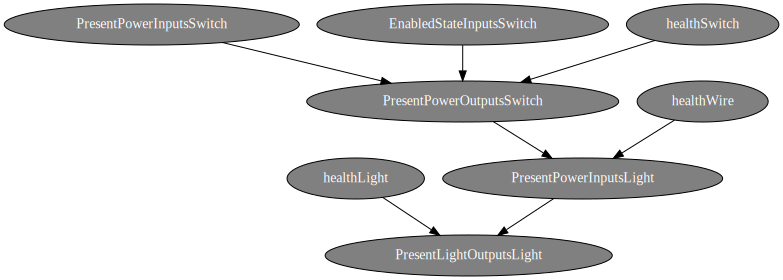

In [307]:
diagram = gum.InfluenceDiagram()
buildSystem(diagram, system)
print(diagram)
gnb.showInfluenceDiagram(diagram, size=60)